**Fetching and Generating Data**

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Step 1: Fetch the list of top 500 companies
def get_top500_companies():
    # Placeholder: Replace with actual top 500 tickers
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'FB']
    return tickers

# Step 2: Fetch weekly stock price data
def fetch_weekly_stock_data(ticker_list, start_date, end_date):
    stock_data = {}
    for ticker in ticker_list:
        stock_df = yf.download(ticker, start=start_date, end=end_date, interval='1wk')
        stock_data[ticker] = stock_df
    return stock_data

# Step 3: Simulate ESG data (constant value per company)
def generate_esg_data(ticker_list):
    np.random.seed(42)
    esg_data = {ticker: {'ESG': np.random.randint(50, 100)} for ticker in ticker_list}
    return pd.DataFrame(esg_data).T

# Step 4: Merge stock and ESG data
def merge_stock_esg(stock_data, esg_data):
    merged_data = {}
    for ticker, stock_df in stock_data.items():
        stock_df['Ticker'] = ticker
        stock_df['ESG'] = esg_data.loc[ticker, 'ESG']
        merged_data[ticker] = stock_df
    return pd.concat(merged_data.values())

# Example usage for fetching and merging data
ticker_list = get_top500_companies()
start_date = '2023-01-01'
end_date = '2024-01-01'

# Fetch data
stock_data = fetch_weekly_stock_data(ticker_list, start_date, end_date)
esg_data = generate_esg_data(ticker_list)

# Merge stock and ESG data
merged_data = merge_stock_esg(stock_data, esg_data)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
<ipython-input-9-239275108a58>:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat(merged_data.values())


**Calculating Risk and Preprocessing for LSTM**

In [15]:
# Step 5: Calculate Value at Risk (VaR) based on weekly stock prices
def calculate_var(merged_data, confidence_level=0.05):
    merged_data['Returns'] = merged_data.groupby('Ticker')['Close'].pct_change()
    returns = merged_data.groupby('Ticker')['Returns'].apply(pd.Series).reset_index()
    sorted_returns = np.sort(returns['Returns']) # Sort by the 'Returns' column
    index = int((1 - confidence_level) * len(sorted_returns))
    risk = abs(sorted_returns[index])
    risk_df = pd.DataFrame({'Risk': [risk]})
    return merged_data.assign(Risk=risk) # Assign the calculated risk to all rows


# Step 6: Preprocess data for LSTM (scaling and sequencing)
def create_sequences(data, time_steps=4):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps])
    return np.array(sequences)

def preprocess_for_lstm(merged_data, lookback=4):
    scaler = MinMaxScaler()
    tickers = merged_data['Ticker'].unique()

    X = []
    y = []

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()
        ticker_data['Returns'] = ticker_data['Close'].pct_change()
        features = ticker_data[['Close']].values
        scaled_features = scaler.fit_transform(features)

        # Create sequences with lookback period
        for i in range(len(scaled_features) - lookback):
            X.append(scaled_features[i:i + lookback])
            y.append(scaled_features[i + lookback][0])  # Next week's price

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

# Example usage
merged_data_with_risk = calculate_var(merged_data)
X, y, scaler = preprocess_for_lstm(merged_data_with_risk)

**Training LSTM Model and Predicting Future price**

In [17]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Step 7: Define and train LSTM model (unchanged)
def train_lstm_model(X, y):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)  # Predicting the stock price
    ])

    model.compile(optimizer='adam', loss='mse')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    return model, X_test, y_test

# Step 8: Predict stock prices for the future date (use future_weeks only here)
def predict_future_prices(model, merged_data, scaler, future_weeks, lookback=4):
    tickers = merged_data['Ticker'].unique()
    predictions = []

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()
        features = ticker_data[['Close']].values
        scaled_features = scaler.transform(features)

        # Get the last lookback weeks of data for each ticker
        input_sequence = scaled_features[-lookback:]

        # Predict multiple weeks into the future
        for _ in range(future_weeks):
            input_sequence = input_sequence.reshape(1, lookback, 1)
            predicted_price = model.predict(input_sequence)
            predictions.append(scaler.inverse_transform(predicted_price)[0][0])  # Inverse transform the price
            # Shift the input sequence forward to predict further weeks
            input_sequence = np.append(input_sequence[0][1:], predicted_price).reshape(lookback, 1)

    return np.array(predictions)


# Step 9: Calculate price growth
def calculate_price_growth(merged_data, predictions, future_weeks):
    tickers = merged_data['Ticker'].unique()
    merged_data['Price Growth'] = 0.0  # Initialize

    for i, ticker in enumerate(tickers):
        ticker_indices = merged_data[merged_data['Ticker'] == ticker].index[-len(predictions):]
        merged_data.loc[ticker_indices, 'Price Growth'] = predictions[i] - merged_data.loc[ticker_indices, 'Close']

    return merged_data



**Ranking and Recommendations**

In [20]:
# Step 10: Rank companies based on user-defined formula score = a * esg_score - b * var + c * price_growth
def recommend_investments(merged_data, a, b, c, future_weeks):
    # Calculate VaR for each company
    merged_data['Returns'] = merged_data.groupby('Ticker')['Close'].pct_change() # Add this line to calculate Returns
    tickers = merged_data['Ticker'].unique()
    for ticker in tickers:
        ticker_returns = merged_data[merged_data['Ticker'] == ticker]['Returns'].dropna()

        # Calculate VaR without grouping by 'Ticker' since we're already filtering by ticker
        sorted_returns = np.sort(ticker_returns)
        index = int((1 - 0.05) * len(sorted_returns)) # Use confidence_level=0.05
        VaR = abs(sorted_returns[index])

        merged_data.loc[merged_data['Ticker'] == ticker, 'VaR'] = VaR

    # Calculate the score based on user parameters
    merged_data['Score'] = (a * merged_data['ESG']) - (b * merged_data['VaR']) + (c * merged_data['Price Growth'])

    # Rank the companies based on the score
    recommended_investments = merged_data.sort_values(by='Score', ascending=False)
    return recommended_investments[['Ticker', 'ESG', 'VaR', 'Price Growth', 'Score']].drop_duplicates('Ticker')

# Example usage with user input
ticker_list = get_top500_companies()
start_date = '2023-01-01'
end_date = '2024-01-01'
future_date = '2024-12-31'

# Fetch stock and ESG data
stock_data = fetch_weekly_stock_data(ticker_list, start_date, end_date)
esg_data = generate_esg_data(ticker_list)

# Merge stock and ESG data
merged_data = merge_stock_esg(stock_data, esg_data)

# Calculate number of weeks from today to the future date
future_weeks = (pd.to_datetime(future_date) - pd.to_datetime(end_date)).days // 7

# Preprocess data for LSTM (independent of future_weeks)
X, y, scaler = preprocess_for_lstm(merged_data)

# Train the LSTM model
model, X_test, y_test = train_lstm_model(X, y)

# Predict stock prices for the future date using future_weeks
predictions = predict_future_prices(model, merged_data, scaler, future_weeks)

# Calculate price growth
merged_data_with_growth = calculate_price_growth(merged_data, predictions, future_weeks)

# User-defined parameters for ranking
a = 1.0  # Weight for ESG score
b = 0.5  # Weight for VaR (risk)
c = 1.5  # Weight for Price Growth

# Get investment recommendations based on user inputs
recommendations = recommend_investments(merged_data_with_growth, a, b, c, future_weeks)
print(recommendations.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
<ipython-input-9-239275108a58>:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat(merged_data.values())
/usr/local/lib/python3.10/dist-packages/keras/src/l

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.4435 - val_loss: 0.3954
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2811 - val_loss: 0.2470
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1601 - val_loss: 0.1063
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0590 - val_loss: 0.0222
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0175 - val_loss: 0.0411
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0339 - val_loss: 0.0230
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0155 - val_loss: 0.0242
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0151 - val_loss: 0.0272
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0160 - val_loss: 0.0220
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0116 - val_loss: 0.0205
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0118 - val_loss: 0.0206
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0121 - val_loss: 0.0209
E

In [22]:
# Step 8: Predict stock prices for the next month (4 weeks)
def predict_next_month_prices(model, merged_data, scaler, lookback=4, future_weeks=4):
    tickers = merged_data['Ticker'].unique()
    future_predictions = {}

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()
        features = ticker_data[['Close']].values
        scaled_features = scaler.transform(features)

        # Get the last lookback weeks of data for each ticker
        input_sequence = scaled_features[-lookback:]

        # Predict multiple weeks into the future (4 weeks in this case)
        future_prices = []
        for _ in range(future_weeks):
            input_sequence = input_sequence.reshape(1, lookback, 1)
            predicted_price = model.predict(input_sequence)
            future_prices.append(scaler.inverse_transform(predicted_price)[0][0])  # Inverse transform the price
            # Shift the input sequence forward to predict further weeks
            input_sequence = np.append(input_sequence[0][1:], predicted_price).reshape(lookback, 1)

        future_predictions[ticker] = future_prices

    return future_predictions

In [28]:
# Step 9: Plot past and predicted future prices
import matplotlib.pyplot as plt


def plot_stock_predictions(merged_data, future_predictions, future_weeks=4):
    tickers = merged_data['Ticker'].unique()

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker]
        actual_prices = ticker_data['Close'].values

        # Create a time axis for both past and future data
        past_dates = ticker_data.index
        future_dates = pd.date_range(start=past_dates[-1], periods=future_weeks + 1, freq='W')[1:]  # 4 weeks future

        # Plot the actual stock price (solid line)
        plt.figure(figsize=(10, 6))
        plt.plot(past_dates, actual_prices, label=f"Actual {ticker} Price", color='blue')

        # Plot the predicted stock prices for the next 4 weeks (dashed line)
        plt.plot(future_dates, future_predictions[ticker], label=f"Predicted {ticker} Price (Next 4 Weeks)", linestyle='--', color='red')

        plt.title(f'{ticker} Stock Price Prediction for the Next Month')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
<ipython-input-3-5007821d6b82>:35: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pd.concat(merged_data.values())
/usr/local/lib/python3.10/dist-packages/keras/src/l

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.4408 - val_loss: 0.2199
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1348 - val_loss: 0.0385
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0278 - val_loss: 0.0903
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0449 - val_loss: 0.0373
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0144 - val_loss: 0.0433
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0241 - val_loss: 0.0414
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0175 - val_loss: 0.0346
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0127 - val_loss: 0.0388
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0151 - val_loss: 0.0363
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0151 - val_loss: 0.0341
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0118 - val_loss: 0.0342
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0118 - val_loss: 0.0338


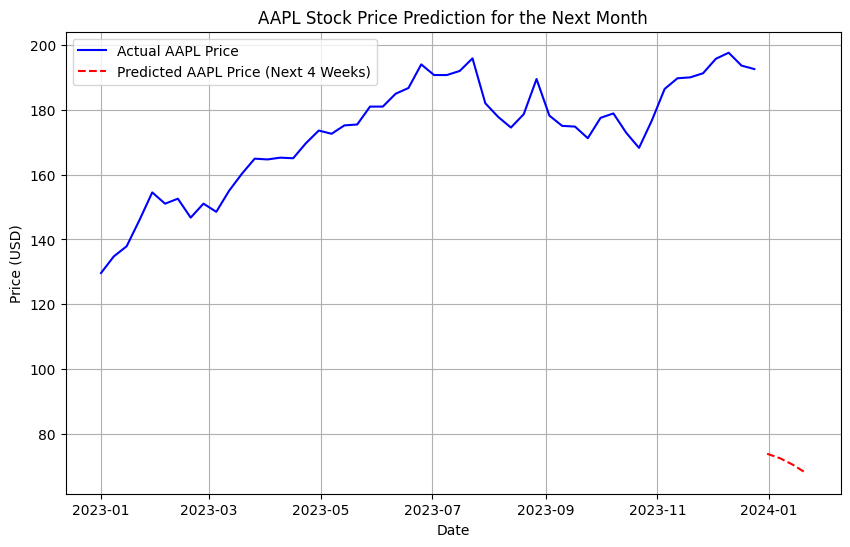

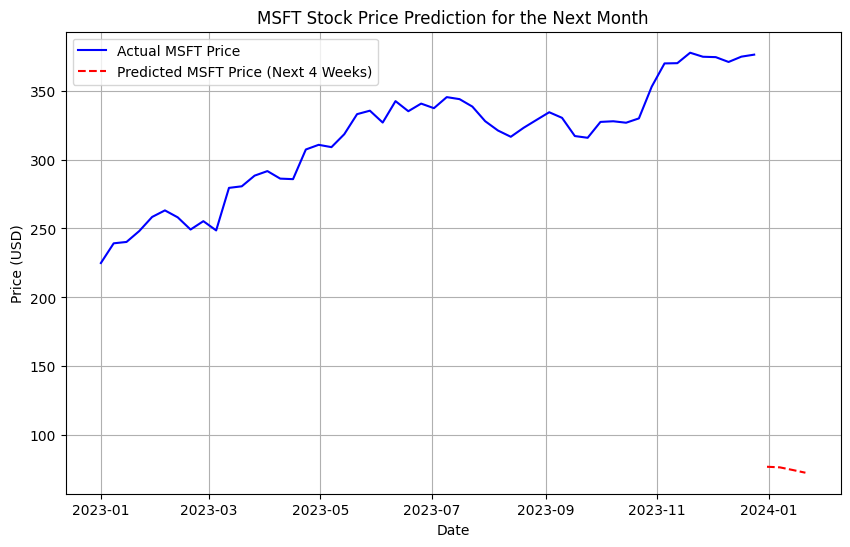

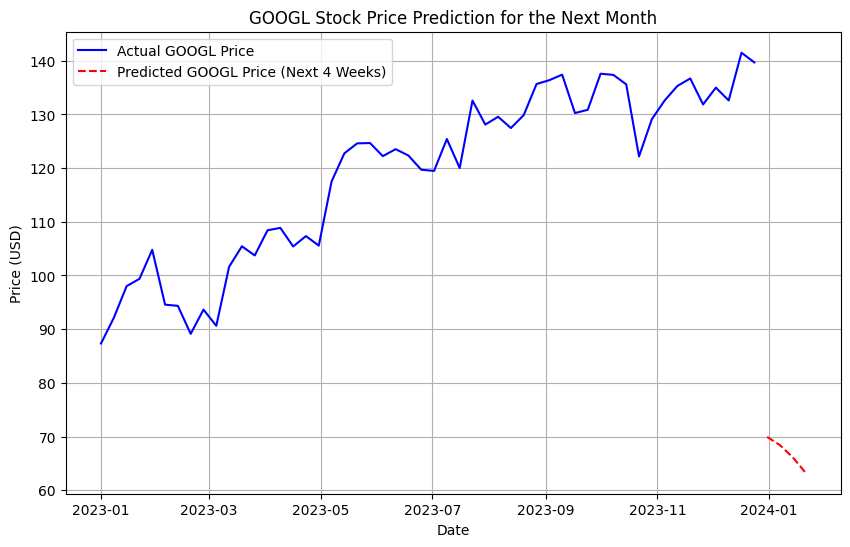

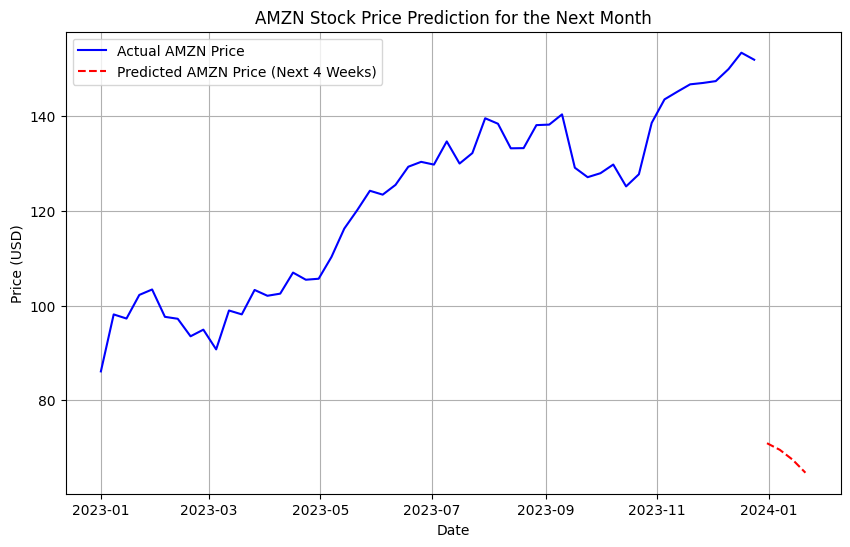

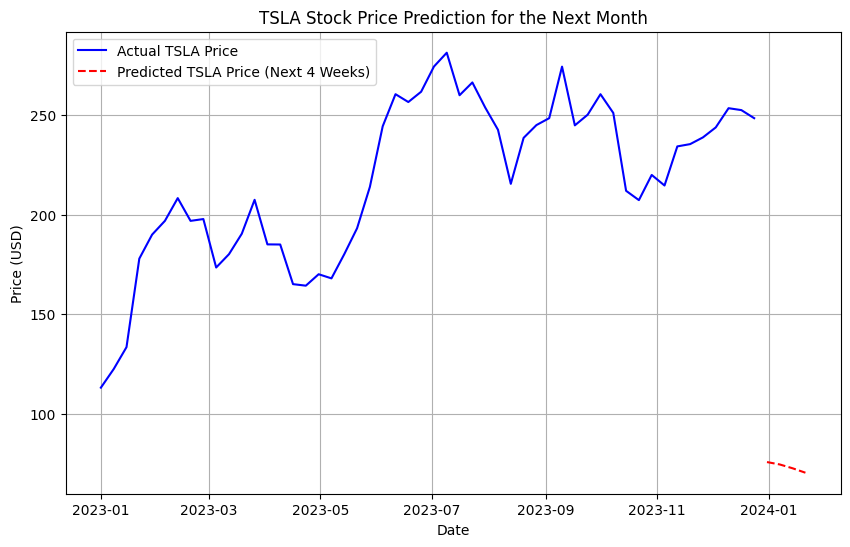

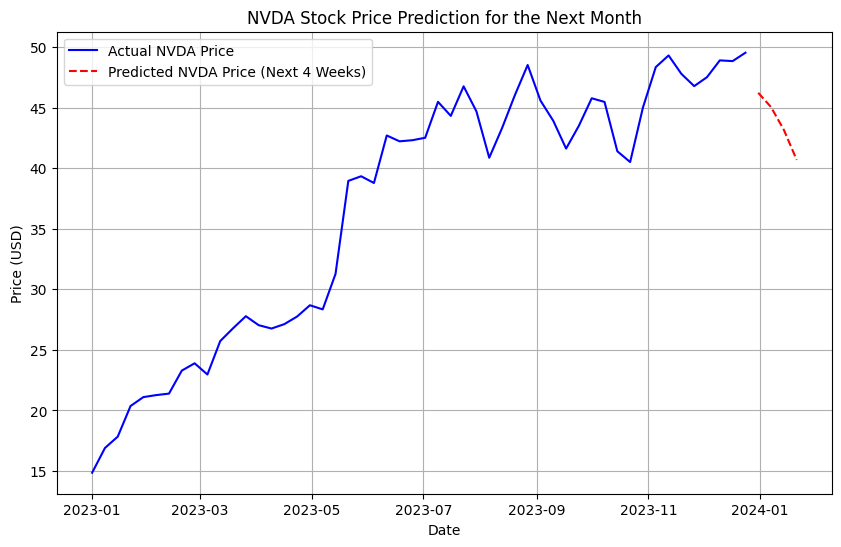

In [29]:
# Example usage

# Step 1: Get top 500 companies
ticker_list = get_top500_companies()
start_date = '2023-01-01'
end_date = '2024-01-01'

# Step 2: Fetch stock and ESG data
stock_data = fetch_stock_data(ticker_list, start_date, end_date)
esg_data = generate_esg_data(ticker_list)

# Step 3: Merge stock and ESG data
merged_data = merge_data(stock_data, esg_data)

# Step 6: Preprocess data for LSTM (independent of future_weeks)
X, y, scaler = preprocess_for_lstm(merged_data)

# Step 7: Train the LSTM model
model, X_test, y_test = train_lstm_model(X, y)

# Step 8: Predict stock prices for the next 4 weeks (1 month)
future_predictions = predict_next_month_prices(model, merged_data, scaler, future_weeks=4)

# Step 9: Plot the predictions for each company
plot_stock_predictions(merged_data, future_predictions)

In [27]:
# Step 6: Preprocess data for LSTM (independent of future_weeks, using a longer lookback window)
def preprocess_for_lstm(merged_data, lookback=12):
    scaler = MinMaxScaler()
    tickers = merged_data['Ticker'].unique()

    X = []
    y = []

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()
        features = ticker_data[['Close']].values  # Using only Close price for now
        scaled_features = scaler.fit_transform(features)

        # Create sequences with lookback period
        for i in range(len(scaled_features) - lookback):
            X.append(scaled_features[i:i + lookback])
            y.append(scaled_features[i + lookback][0])  # Next week's price

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

# Step 8: Predict stock prices for the next month (4 weeks)
def predict_next_month_prices(model, merged_data, scaler, lookback=12, future_weeks=4):
    tickers = merged_data['Ticker'].unique()
    future_predictions = {}

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()
        features = ticker_data[['Close']].values
        scaled_features = scaler.transform(features)

        # Get the last lookback weeks of data for each ticker
        input_sequence = scaled_features[-lookback:]

        # Predict multiple weeks into the future (4 weeks in this case)
        future_prices = []
        for _ in range(future_weeks):
            input_sequence = input_sequence.reshape(1, lookback, 1)
            predicted_price = model.predict(input_sequence)
            future_prices.append(scaler.inverse_transform(predicted_price)[0][0])  # Inverse transform the price
            # Shift the input sequence forward to predict further weeks
            input_sequence = np.append(input_sequence[0][1:], scaler.transform(predicted_price.reshape(1, -1))).reshape(lookback, 1)

        future_predictions[ticker] = future_prices

    return future_predictions
